In [26]:
import torch
from sklearn.datasets import make_friedman1
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

import numpy as np
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Generate data

In [33]:
X, y = make_friedman1(n_samples= 150000, n_features= 10, noise=0.1)
X.shape

(150000, 10)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=42)

# Find BaseLine

In [35]:
lr = LinearRegression()
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)
baseline_r2 = r2_score(y_test, predictions)
baseline_mape = mean_absolute_percentage_error(y_test, predictions)
baseline_mse =  mean_squared_error(y_test, predictions)
print("baseline", baseline_r2, baseline_mape, baseline_mse)

baseline 0.7978334346649476 0.1361053444367123 4.626982104972194


# Prepare data

In [36]:
X_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

In [37]:
Batch = 256
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader =  DataLoader(train_dataset, batch_size=Batch)
test_loader =  DataLoader(test_dataset, batch_size=Batch)

In [38]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [39]:
DEVICE

'cuda'

# Model

In [40]:
class NeuralNetwork(nn.Module):
  def __init__(self, number_layers, in_features, out_features):
    super(NeuralNetwork, self).__init__()
    self.layers = nn.ModuleList()

    for i in range(number_layers):
      self.layers.append(nn.Linear(in_features, 10))
      self.layers.append(nn.ReLU())

    self.layers.append(nn.Linear(10, out_features))

  def forward(self, x):
    for layer in self.layers:
      x = layer(x.float())
    return x


# Train and visualize

In [41]:
def train(model, type_optimizers, learning_rate):
  optimizers = None

  if type_optimizers == "Adam":
    optimizers = torch.optim.Adam(model.parameters(), lr=learning_rate)
  if type_optimizers == "SGD":
    optimizers = torch.optim.SGD(model.parameters(), lr=learning_rate)
  if type_optimizers == "RMS":
    optimizers = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

  loss_function = nn.MSELoss()
  model = model.to(DEVICE)

  train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = [], [], [], [], [], []

  EPOCH = 50
  for iteration in range(EPOCH):
    model.train()
    mse, mape, r2 = [], [], []

    for input, output in train_loader:
      optimizers.zero_grad()
      result = model(input.to(DEVICE))
      result = result.view(-1)
      loss = loss_function(result, output.float().to(DEVICE))
      loss.backward()

      mse.append(loss.detach().cpu().numpy().item())
      MAPE = mean_absolute_percentage_error(output.detach().cpu().numpy(), result.detach().cpu().numpy())
      mape.append(MAPE)
      R2 = r2_score(output.detach().cpu().numpy(), result.detach().cpu().numpy())
      r2.append(R2)

      optimizers.step()


    train_mse.append(np.mean(mse))
    train_mape.append(np.mean(mape))
    train_r2.append(np.mean(r2))

    mse_val, mape_val, r2_val = [], [], []

    for input, output in test_loader:
      model.eval()

      with torch.no_grad():
        result = model(input.to(DEVICE))
        result = result.view(-1)
        loss = loss_function(result, output.float().to(DEVICE))
        mse_val.append(loss.detach().cpu().numpy().item())
        MAPE = mean_absolute_percentage_error(output.detach().cpu().numpy(), result.detach().cpu().numpy())
        mape_val.append(MAPE)
        R2 = r2_score(output.detach().cpu().numpy(), result.detach().cpu().numpy())
        r2_val.append(R2)

    test_mse.append(np.mean(mse_val))
    test_mape.append(np.mean(mape_val))
    test_r2.append(np.mean(r2_val))
    print(f"Epoch {iteration + 1}/{EPOCH} - Train MSE: {train_mse[-1]:.4f}, Test MSE: {test_mse[-1]:.4f}")

  return train_r2, test_r2, train_mape, test_mape, train_mse, test_mse

In [42]:
def draw(title, train_r2, test_r2, train_mape, test_mape, train_mse, test_mse):
  epochs = range(len(train_mse))
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, train_mse, label="Train MSE", linestyle="-", color='blue')
  plt.plot(epochs, test_mse, label="Test MSE", linestyle="-", color='lightblue')
  plt.plot(epochs, train_r2, label="Train R2", linestyle="-", color='green')
  plt.plot(epochs, test_r2, label="Test R2", linestyle="-", color='lightgreen')
  plt.plot(epochs, train_mape, label="Train MAPE", linestyle="-", color='red')
  plt.plot(epochs, test_mape, label="Test MAPE", linestyle="-", color='orange')

  plt.xlabel("Epochs")
  plt.ylabel("Metrics")
  plt.title(title)
  plt.legend()
  plt.show()

# Test Models

In [45]:
model = NeuralNetwork(1, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "SGD", 0.1)

Epoch 1/50 - Train MSE: 25.1751, Test MSE: 12.0332
Epoch 2/50 - Train MSE: 12.8180, Test MSE: 22.9014
Epoch 3/50 - Train MSE: 11.5494, Test MSE: 9.5095
Epoch 4/50 - Train MSE: 10.7199, Test MSE: 10.4750
Epoch 5/50 - Train MSE: 10.7075, Test MSE: 8.2508
Epoch 6/50 - Train MSE: 9.7538, Test MSE: 8.0870
Epoch 7/50 - Train MSE: 5.9167, Test MSE: 4.8090
Epoch 8/50 - Train MSE: 5.3783, Test MSE: 3.9871
Epoch 9/50 - Train MSE: 5.2115, Test MSE: 3.6472
Epoch 10/50 - Train MSE: 5.0958, Test MSE: 3.4893
Epoch 11/50 - Train MSE: 5.0245, Test MSE: 3.3629
Epoch 12/50 - Train MSE: 4.9763, Test MSE: 3.3034
Epoch 13/50 - Train MSE: 4.9480, Test MSE: 3.2536
Epoch 14/50 - Train MSE: 4.9368, Test MSE: 3.2036
Epoch 15/50 - Train MSE: 4.9293, Test MSE: 3.1911
Epoch 16/50 - Train MSE: 4.9244, Test MSE: 3.1832
Epoch 17/50 - Train MSE: 4.9203, Test MSE: 3.1861
Epoch 18/50 - Train MSE: 4.9156, Test MSE: 3.1768
Epoch 19/50 - Train MSE: 4.9135, Test MSE: 3.1650
Epoch 20/50 - Train MSE: 4.9111, Test MSE: 3.1632
E

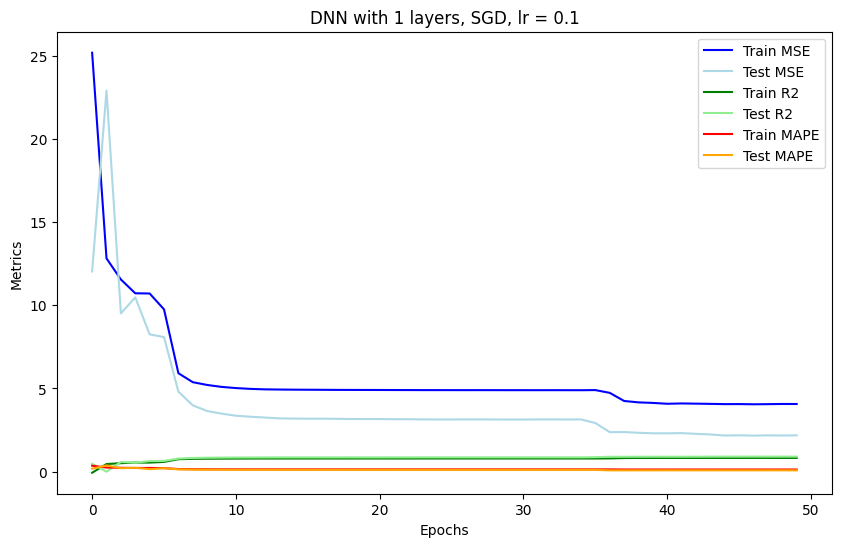

In [46]:
draw("DNN with 1 layers, SGD, lr = 0.1", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [50]:
model = NeuralNetwork(1, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "SGD", 0.01)

Epoch 1/50 - Train MSE: 7.8219, Test MSE: 4.6579
Epoch 2/50 - Train MSE: 5.9630, Test MSE: 4.6638
Epoch 3/50 - Train MSE: 5.9036, Test MSE: 4.6802
Epoch 4/50 - Train MSE: 5.7247, Test MSE: 4.6849
Epoch 5/50 - Train MSE: 5.3703, Test MSE: 4.7019
Epoch 6/50 - Train MSE: 4.8488, Test MSE: 4.5544
Epoch 7/50 - Train MSE: 3.9033, Test MSE: 3.8906
Epoch 8/50 - Train MSE: 3.1996, Test MSE: 3.4063
Epoch 9/50 - Train MSE: 3.0502, Test MSE: 3.2539
Epoch 10/50 - Train MSE: 3.0234, Test MSE: 3.2120
Epoch 11/50 - Train MSE: 3.0080, Test MSE: 3.1854
Epoch 12/50 - Train MSE: 2.9972, Test MSE: 3.1784
Epoch 13/50 - Train MSE: 2.9888, Test MSE: 3.1733
Epoch 14/50 - Train MSE: 2.9825, Test MSE: 3.1734
Epoch 15/50 - Train MSE: 2.9768, Test MSE: 3.1719
Epoch 16/50 - Train MSE: 2.9724, Test MSE: 3.1728
Epoch 17/50 - Train MSE: 2.9686, Test MSE: 3.1763
Epoch 18/50 - Train MSE: 2.9658, Test MSE: 3.1787
Epoch 19/50 - Train MSE: 2.9630, Test MSE: 3.1798
Epoch 20/50 - Train MSE: 2.9603, Test MSE: 3.1791
Epoch 21/

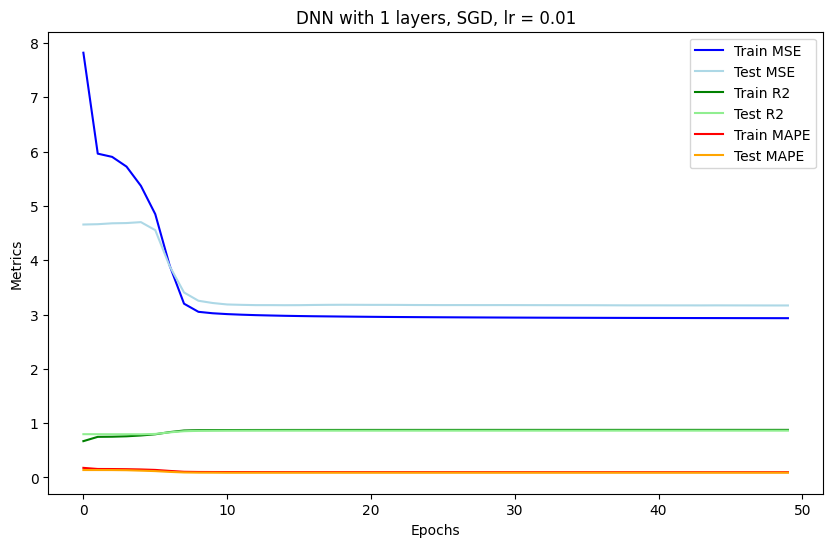

In [52]:
draw("DNN with 1 layers, SGD, lr = 0.01", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [53]:
model = NeuralNetwork(1, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "SGD", 0.001)

Epoch 1/50 - Train MSE: 22.9978, Test MSE: 7.2642
Epoch 2/50 - Train MSE: 6.7636, Test MSE: 5.1841
Epoch 3/50 - Train MSE: 6.0875, Test MSE: 4.8803
Epoch 4/50 - Train MSE: 5.9878, Test MSE: 4.7490
Epoch 5/50 - Train MSE: 5.9497, Test MSE: 4.6848
Epoch 6/50 - Train MSE: 5.9331, Test MSE: 4.6516
Epoch 7/50 - Train MSE: 5.9258, Test MSE: 4.6331
Epoch 8/50 - Train MSE: 5.9223, Test MSE: 4.6219
Epoch 9/50 - Train MSE: 5.9206, Test MSE: 4.6146
Epoch 10/50 - Train MSE: 5.9194, Test MSE: 4.6094
Epoch 11/50 - Train MSE: 5.9185, Test MSE: 4.6053
Epoch 12/50 - Train MSE: 5.9177, Test MSE: 4.6015
Epoch 13/50 - Train MSE: 5.9167, Test MSE: 4.5981
Epoch 14/50 - Train MSE: 5.9156, Test MSE: 4.5946
Epoch 15/50 - Train MSE: 5.9143, Test MSE: 4.5909
Epoch 16/50 - Train MSE: 5.9128, Test MSE: 4.5870
Epoch 17/50 - Train MSE: 5.9110, Test MSE: 4.5827
Epoch 18/50 - Train MSE: 5.9087, Test MSE: 4.5780
Epoch 19/50 - Train MSE: 5.9060, Test MSE: 4.5728
Epoch 20/50 - Train MSE: 5.9026, Test MSE: 4.5670
Epoch 21

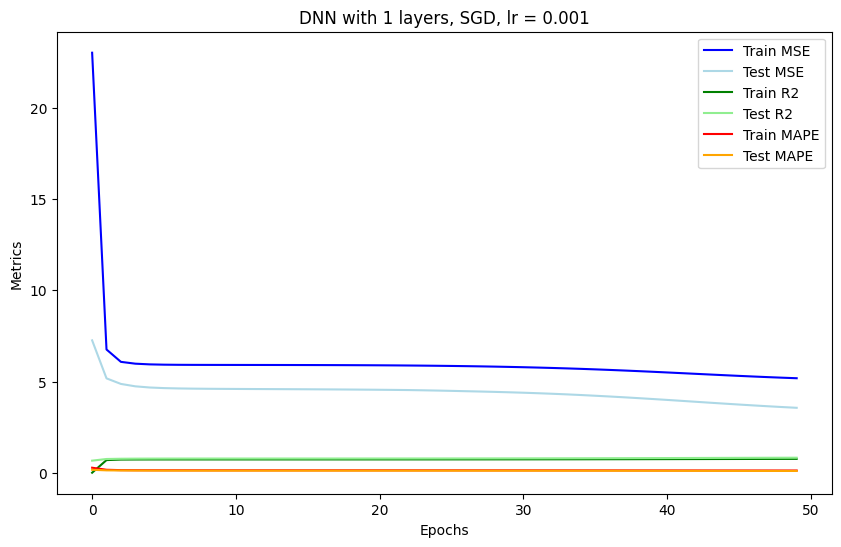

In [54]:
draw("DNN with 1 layers, SGD, lr = 0.001", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [55]:
model = NeuralNetwork(1, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "RMS", 0.1)

Epoch 1/50 - Train MSE: 10.4055, Test MSE: 4.0504
Epoch 2/50 - Train MSE: 5.6404, Test MSE: 3.5819
Epoch 3/50 - Train MSE: 5.2917, Test MSE: 3.6701
Epoch 4/50 - Train MSE: 4.5203, Test MSE: 3.5720
Epoch 5/50 - Train MSE: 3.7889, Test MSE: 3.9914
Epoch 6/50 - Train MSE: 3.6385, Test MSE: 4.2283
Epoch 7/50 - Train MSE: 3.5526, Test MSE: 4.2775
Epoch 8/50 - Train MSE: 3.4983, Test MSE: 4.4134
Epoch 9/50 - Train MSE: 3.4552, Test MSE: 4.6047
Epoch 10/50 - Train MSE: 3.4243, Test MSE: 4.7293
Epoch 11/50 - Train MSE: 3.3957, Test MSE: 5.0599
Epoch 12/50 - Train MSE: 3.3750, Test MSE: 5.3761
Epoch 13/50 - Train MSE: 3.3487, Test MSE: 5.1816
Epoch 14/50 - Train MSE: 3.3343, Test MSE: 5.3610
Epoch 15/50 - Train MSE: 3.3221, Test MSE: 5.3988
Epoch 16/50 - Train MSE: 3.3094, Test MSE: 5.3715
Epoch 17/50 - Train MSE: 3.3003, Test MSE: 5.2981
Epoch 18/50 - Train MSE: 3.2916, Test MSE: 5.2650
Epoch 19/50 - Train MSE: 3.2839, Test MSE: 5.1851
Epoch 20/50 - Train MSE: 3.2783, Test MSE: 5.2308
Epoch 21

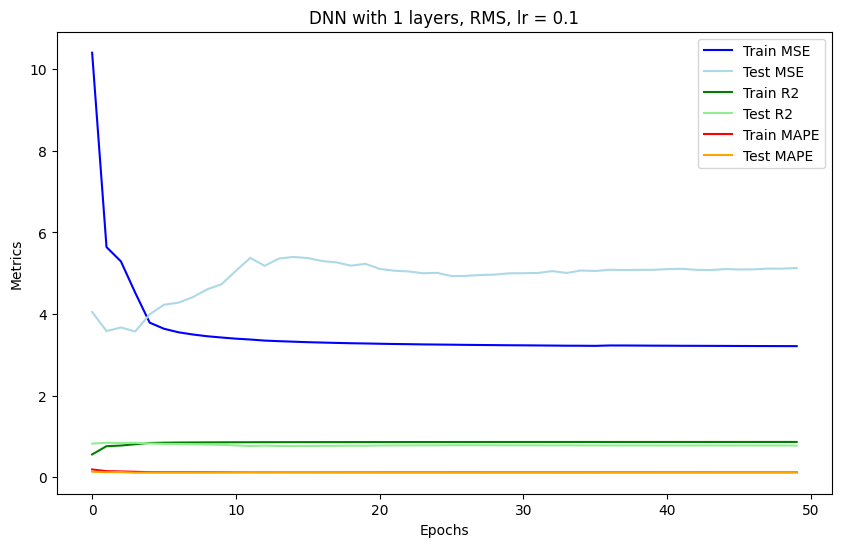

In [57]:
draw("DNN with 1 layers, RMS, lr = 0.1", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [58]:
model = NeuralNetwork(1, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "RMS", 0.01)

Epoch 1/50 - Train MSE: 10.1201, Test MSE: 4.1395
Epoch 2/50 - Train MSE: 5.1105, Test MSE: 2.9028
Epoch 3/50 - Train MSE: 4.4407, Test MSE: 3.3125
Epoch 4/50 - Train MSE: 4.1738, Test MSE: 3.1846
Epoch 5/50 - Train MSE: 3.9147, Test MSE: 3.0766
Epoch 6/50 - Train MSE: 3.7147, Test MSE: 2.9510
Epoch 7/50 - Train MSE: 3.5705, Test MSE: 2.8430
Epoch 8/50 - Train MSE: 3.4615, Test MSE: 2.7405
Epoch 9/50 - Train MSE: 3.3772, Test MSE: 2.6590
Epoch 10/50 - Train MSE: 3.3114, Test MSE: 2.6081
Epoch 11/50 - Train MSE: 3.2596, Test MSE: 2.5663
Epoch 12/50 - Train MSE: 3.2176, Test MSE: 2.5246
Epoch 13/50 - Train MSE: 3.1838, Test MSE: 2.4908
Epoch 14/50 - Train MSE: 3.1563, Test MSE: 2.4556
Epoch 15/50 - Train MSE: 3.1369, Test MSE: 2.4214
Epoch 16/50 - Train MSE: 3.1189, Test MSE: 2.3839
Epoch 17/50 - Train MSE: 3.1032, Test MSE: 2.3484
Epoch 18/50 - Train MSE: 3.0905, Test MSE: 2.3187
Epoch 19/50 - Train MSE: 3.0793, Test MSE: 2.2916
Epoch 20/50 - Train MSE: 3.0695, Test MSE: 2.2710
Epoch 21

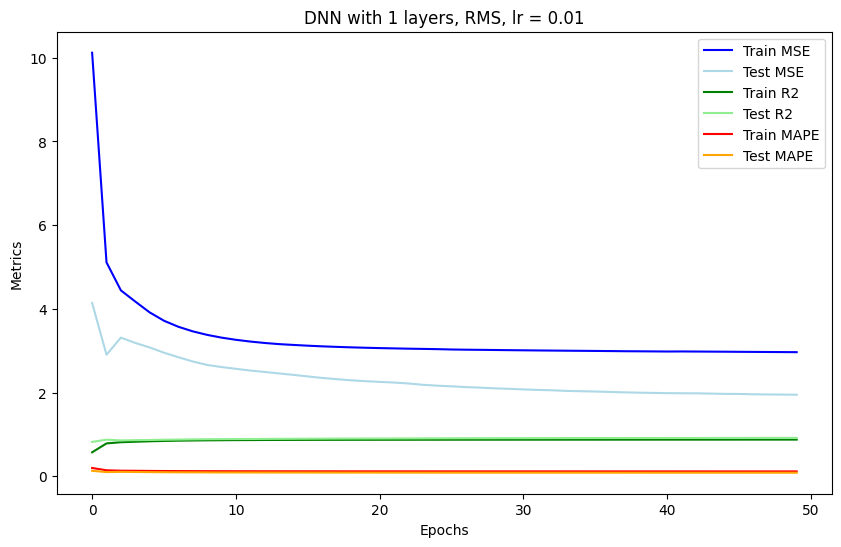

In [59]:
draw("DNN with 1 layers, RMS, lr = 0.01", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [60]:
model = NeuralNetwork(1, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "RMS", 0.001)

Epoch 1/50 - Train MSE: 61.3985, Test MSE: 15.7721
Epoch 2/50 - Train MSE: 10.9468, Test MSE: 5.7475
Epoch 3/50 - Train MSE: 6.1116, Test MSE: 4.7199
Epoch 4/50 - Train MSE: 5.9317, Test MSE: 4.6772
Epoch 5/50 - Train MSE: 5.9090, Test MSE: 4.6227
Epoch 6/50 - Train MSE: 5.8533, Test MSE: 4.5298
Epoch 7/50 - Train MSE: 5.7615, Test MSE: 4.4408
Epoch 8/50 - Train MSE: 5.6462, Test MSE: 4.3614
Epoch 9/50 - Train MSE: 5.5119, Test MSE: 4.2780
Epoch 10/50 - Train MSE: 5.3646, Test MSE: 4.1288
Epoch 11/50 - Train MSE: 5.2112, Test MSE: 3.9630
Epoch 12/50 - Train MSE: 5.0578, Test MSE: 3.7985
Epoch 13/50 - Train MSE: 4.9086, Test MSE: 3.6246
Epoch 14/50 - Train MSE: 4.7666, Test MSE: 3.4384
Epoch 15/50 - Train MSE: 4.6335, Test MSE: 3.2393
Epoch 16/50 - Train MSE: 4.5090, Test MSE: 3.0304
Epoch 17/50 - Train MSE: 4.3898, Test MSE: 2.8067
Epoch 18/50 - Train MSE: 4.2755, Test MSE: 2.6618
Epoch 19/50 - Train MSE: 4.1672, Test MSE: 2.5808
Epoch 20/50 - Train MSE: 4.0667, Test MSE: 2.5184
Epoch 

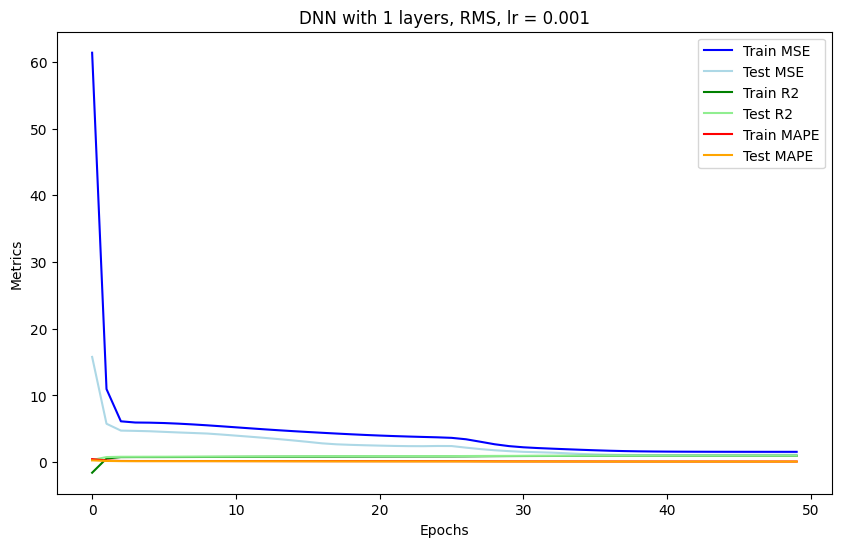

In [61]:
draw("DNN with 1 layers, RMS, lr = 0.001", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [62]:
model = NeuralNetwork(1, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "Adam", 0.1)

Epoch 1/50 - Train MSE: 8.2160, Test MSE: 4.6196
Epoch 2/50 - Train MSE: 6.0879, Test MSE: 4.5779
Epoch 3/50 - Train MSE: 4.9087, Test MSE: 3.3124
Epoch 4/50 - Train MSE: 4.0175, Test MSE: 3.3846
Epoch 5/50 - Train MSE: 4.0125, Test MSE: 3.3748
Epoch 6/50 - Train MSE: 4.0101, Test MSE: 3.3832
Epoch 7/50 - Train MSE: 4.0059, Test MSE: 3.4036
Epoch 8/50 - Train MSE: 3.9995, Test MSE: 3.4267
Epoch 9/50 - Train MSE: 3.9906, Test MSE: 3.4115
Epoch 10/50 - Train MSE: 3.7500, Test MSE: 1.5699
Epoch 11/50 - Train MSE: 1.6969, Test MSE: 1.2894
Epoch 12/50 - Train MSE: 1.6279, Test MSE: 1.2255
Epoch 13/50 - Train MSE: 1.6220, Test MSE: 1.2358
Epoch 14/50 - Train MSE: 1.6203, Test MSE: 1.2360
Epoch 15/50 - Train MSE: 1.6176, Test MSE: 1.2114
Epoch 16/50 - Train MSE: 1.6144, Test MSE: 1.2237
Epoch 17/50 - Train MSE: 1.5930, Test MSE: 1.1439
Epoch 18/50 - Train MSE: 1.5456, Test MSE: 1.0972
Epoch 19/50 - Train MSE: 1.5135, Test MSE: 1.1466
Epoch 20/50 - Train MSE: 1.5039, Test MSE: 1.1541
Epoch 21/

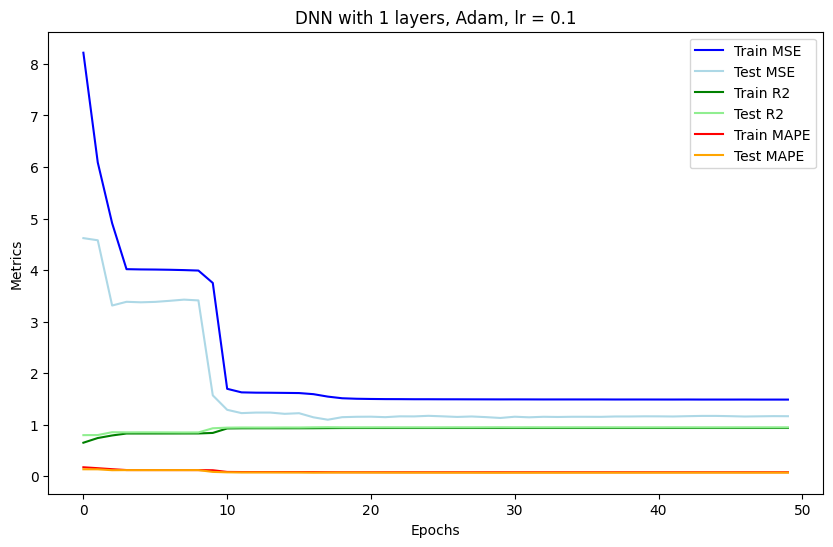

In [63]:
draw("DNN with 1 layers, Adam, lr = 0.1", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [64]:
model = NeuralNetwork(1, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "Adam", 0.01)

Epoch 1/50 - Train MSE: 20.4116, Test MSE: 4.6955
Epoch 2/50 - Train MSE: 5.9455, Test MSE: 4.6838
Epoch 3/50 - Train MSE: 5.9356, Test MSE: 4.6960
Epoch 4/50 - Train MSE: 5.9405, Test MSE: 4.6988
Epoch 5/50 - Train MSE: 5.9475, Test MSE: 4.7452
Epoch 6/50 - Train MSE: 5.9518, Test MSE: 4.8110
Epoch 7/50 - Train MSE: 5.9532, Test MSE: 4.8722
Epoch 8/50 - Train MSE: 5.9536, Test MSE: 4.9070
Epoch 9/50 - Train MSE: 5.9532, Test MSE: 4.9240
Epoch 10/50 - Train MSE: 5.9527, Test MSE: 4.9292
Epoch 11/50 - Train MSE: 5.9515, Test MSE: 4.9277
Epoch 12/50 - Train MSE: 5.9490, Test MSE: 4.9244
Epoch 13/50 - Train MSE: 5.9418, Test MSE: 4.8891
Epoch 14/50 - Train MSE: 5.3104, Test MSE: 3.8985
Epoch 15/50 - Train MSE: 4.0883, Test MSE: 3.5019
Epoch 16/50 - Train MSE: 3.9130, Test MSE: 3.4425
Epoch 17/50 - Train MSE: 3.8820, Test MSE: 3.4445
Epoch 18/50 - Train MSE: 3.8756, Test MSE: 3.4550
Epoch 19/50 - Train MSE: 3.8740, Test MSE: 3.4501
Epoch 20/50 - Train MSE: 3.8733, Test MSE: 3.4510
Epoch 21

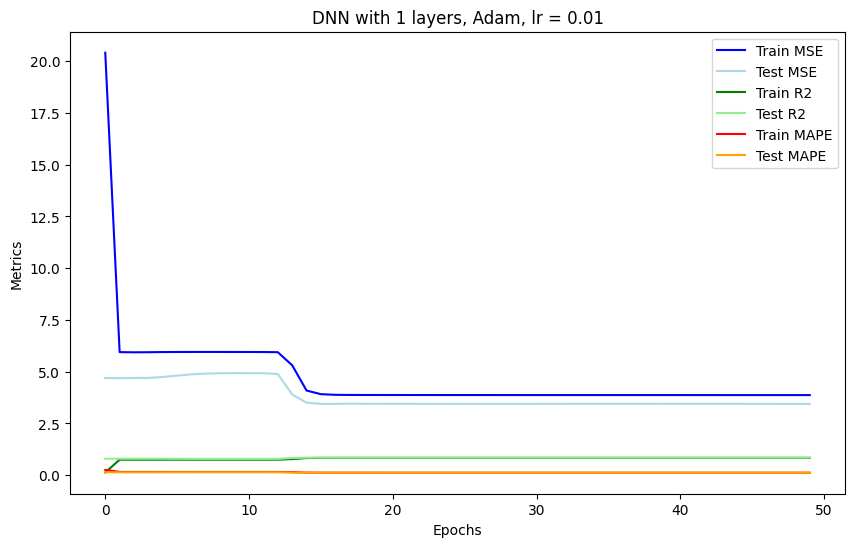

In [66]:
draw("DNN with 1 layers, Adam, lr = 0.01", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [67]:
model = NeuralNetwork(1, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "Adam", 0.001)

Epoch 1/50 - Train MSE: 85.0325, Test MSE: 16.6969
Epoch 2/50 - Train MSE: 14.4540, Test MSE: 12.7530
Epoch 3/50 - Train MSE: 11.1650, Test MSE: 8.6982
Epoch 4/50 - Train MSE: 8.1524, Test MSE: 5.7628
Epoch 5/50 - Train MSE: 6.4512, Test MSE: 4.7701
Epoch 6/50 - Train MSE: 6.0105, Test MSE: 4.6937
Epoch 7/50 - Train MSE: 5.9190, Test MSE: 4.9072
Epoch 8/50 - Train MSE: 5.7461, Test MSE: 5.1049
Epoch 9/50 - Train MSE: 5.5797, Test MSE: 5.1918
Epoch 10/50 - Train MSE: 5.4389, Test MSE: 5.2423
Epoch 11/50 - Train MSE: 5.3251, Test MSE: 5.2848
Epoch 12/50 - Train MSE: 5.2370, Test MSE: 5.3150
Epoch 13/50 - Train MSE: 5.1708, Test MSE: 5.3357
Epoch 14/50 - Train MSE: 5.1215, Test MSE: 5.3424
Epoch 15/50 - Train MSE: 5.0851, Test MSE: 5.3282
Epoch 16/50 - Train MSE: 5.0582, Test MSE: 5.3241
Epoch 17/50 - Train MSE: 5.0384, Test MSE: 5.3047
Epoch 18/50 - Train MSE: 5.0240, Test MSE: 5.2846
Epoch 19/50 - Train MSE: 5.0133, Test MSE: 5.2697
Epoch 20/50 - Train MSE: 5.0053, Test MSE: 5.2437
Epoc

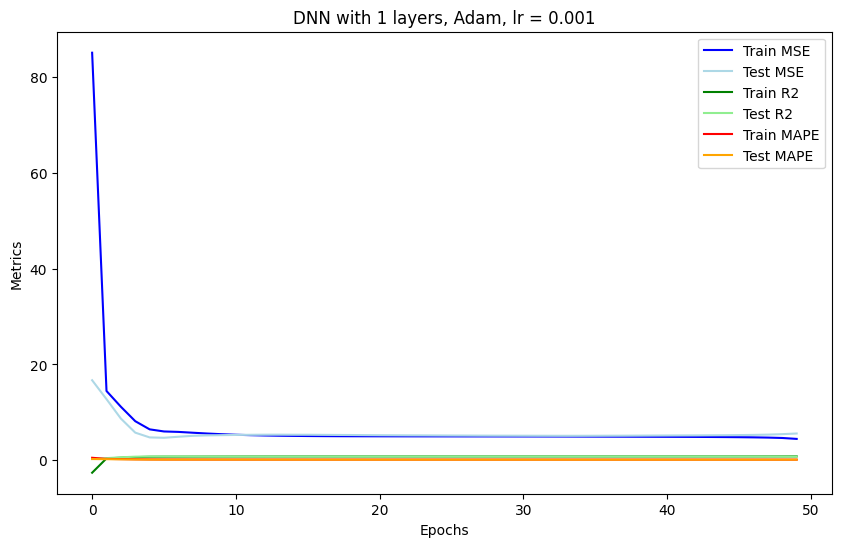

In [68]:
draw("DNN with 1 layers, Adam, lr = 0.001", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [69]:
model = NeuralNetwork(5, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "SGD", 0.1)

Epoch 1/50 - Train MSE: 54.1783, Test MSE: 23.1609
Epoch 2/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 3/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 4/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 5/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 6/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 7/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 8/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 9/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 10/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 11/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 12/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 13/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 14/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 15/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 16/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 17/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 18/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 19/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 20/50 - Train M

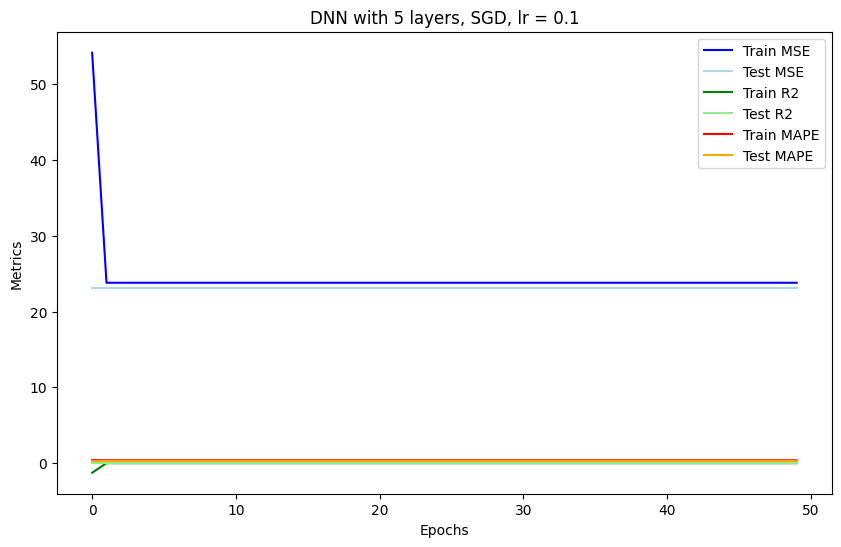

In [70]:
draw("DNN with 5 layers, SGD, lr = 0.1", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [71]:
model = NeuralNetwork(5, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "SGD", 0.01)

Epoch 1/50 - Train MSE: 26.3717, Test MSE: 23.5852
Epoch 2/50 - Train MSE: 20.9109, Test MSE: 7.0527
Epoch 3/50 - Train MSE: 13.2254, Test MSE: 3.7913
Epoch 4/50 - Train MSE: 10.3887, Test MSE: 9.2307
Epoch 5/50 - Train MSE: 8.4820, Test MSE: 18.2647
Epoch 6/50 - Train MSE: 7.0513, Test MSE: 12.5675
Epoch 7/50 - Train MSE: 6.0040, Test MSE: 28.0639
Epoch 8/50 - Train MSE: 5.1152, Test MSE: 2.4993
Epoch 9/50 - Train MSE: 3.3314, Test MSE: 1.7872
Epoch 10/50 - Train MSE: 2.3341, Test MSE: 1.4163
Epoch 11/50 - Train MSE: 1.8972, Test MSE: 1.2272
Epoch 12/50 - Train MSE: 1.6085, Test MSE: 0.7836
Epoch 13/50 - Train MSE: 1.3717, Test MSE: 0.5799
Epoch 14/50 - Train MSE: 1.2145, Test MSE: 0.4938
Epoch 15/50 - Train MSE: 1.1082, Test MSE: 0.4763
Epoch 16/50 - Train MSE: 1.0294, Test MSE: 0.5129
Epoch 17/50 - Train MSE: 0.9742, Test MSE: 0.4846
Epoch 18/50 - Train MSE: 0.9208, Test MSE: 0.3926
Epoch 19/50 - Train MSE: 0.8853, Test MSE: 0.3640
Epoch 20/50 - Train MSE: 0.8361, Test MSE: 0.3326
E

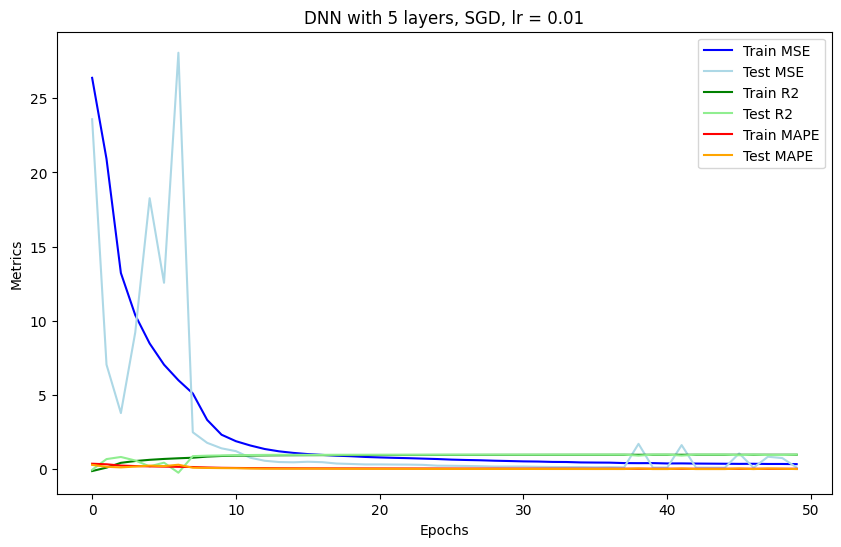

In [72]:
draw("DNN with 5 layers, SGD, lr = 0.01", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [73]:
model = NeuralNetwork(5, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "SGD", 0.001)

Epoch 1/50 - Train MSE: 31.5938, Test MSE: 4.6831
Epoch 2/50 - Train MSE: 5.9363, Test MSE: 4.2065
Epoch 3/50 - Train MSE: 5.6894, Test MSE: 4.1473
Epoch 4/50 - Train MSE: 5.2468, Test MSE: 3.8078
Epoch 5/50 - Train MSE: 4.8233, Test MSE: 3.3033
Epoch 6/50 - Train MSE: 4.6311, Test MSE: 3.0393
Epoch 7/50 - Train MSE: 4.1959, Test MSE: 2.6887
Epoch 8/50 - Train MSE: 3.7801, Test MSE: 2.6960
Epoch 9/50 - Train MSE: 3.5029, Test MSE: 2.5163
Epoch 10/50 - Train MSE: 3.2861, Test MSE: 2.3445
Epoch 11/50 - Train MSE: 3.1403, Test MSE: 2.2816
Epoch 12/50 - Train MSE: 3.0452, Test MSE: 2.2226
Epoch 13/50 - Train MSE: 2.9745, Test MSE: 2.1407
Epoch 14/50 - Train MSE: 2.9280, Test MSE: 2.0853
Epoch 15/50 - Train MSE: 2.8897, Test MSE: 2.0651
Epoch 16/50 - Train MSE: 2.8595, Test MSE: 2.0538
Epoch 17/50 - Train MSE: 2.8363, Test MSE: 2.0561
Epoch 18/50 - Train MSE: 2.8130, Test MSE: 2.0514
Epoch 19/50 - Train MSE: 2.7909, Test MSE: 2.0333
Epoch 20/50 - Train MSE: 2.7680, Test MSE: 1.9981
Epoch 21

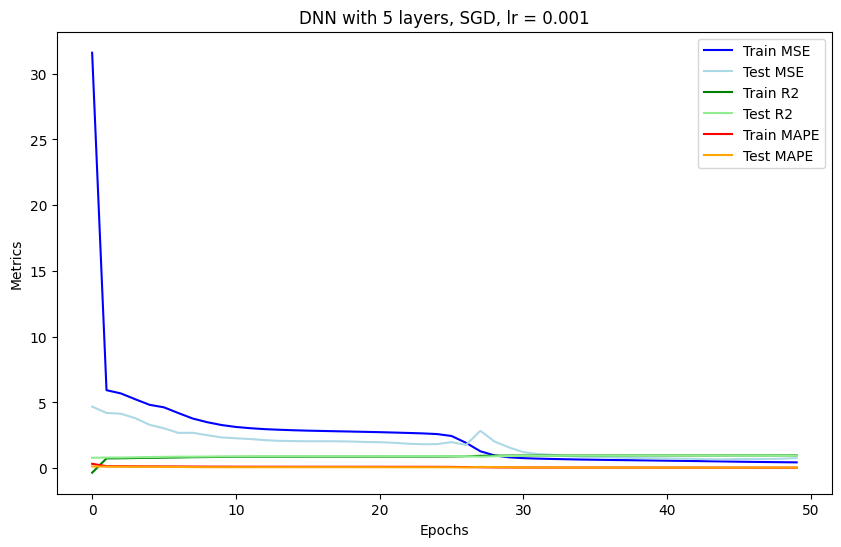

In [74]:
draw("DNN with 5 layers, SGD, lr = 0.001", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [76]:
model = NeuralNetwork(5, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "RMS", 0.1)

Epoch 1/50 - Train MSE: 26.2637, Test MSE: 27.1138
Epoch 2/50 - Train MSE: 24.2702, Test MSE: 26.6933
Epoch 3/50 - Train MSE: 24.2165, Test MSE: 26.1784
Epoch 4/50 - Train MSE: 24.1304, Test MSE: 25.1880
Epoch 5/50 - Train MSE: 24.0491, Test MSE: 24.9542
Epoch 6/50 - Train MSE: 24.0141, Test MSE: 24.6475
Epoch 7/50 - Train MSE: 23.9622, Test MSE: 24.0615
Epoch 8/50 - Train MSE: 23.8985, Test MSE: 23.7872
Epoch 9/50 - Train MSE: 23.8720, Test MSE: 23.5227
Epoch 10/50 - Train MSE: 23.8301, Test MSE: 23.2106
Epoch 11/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 12/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 13/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 14/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 15/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 16/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 17/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 18/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 19/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 20/50 - Train M

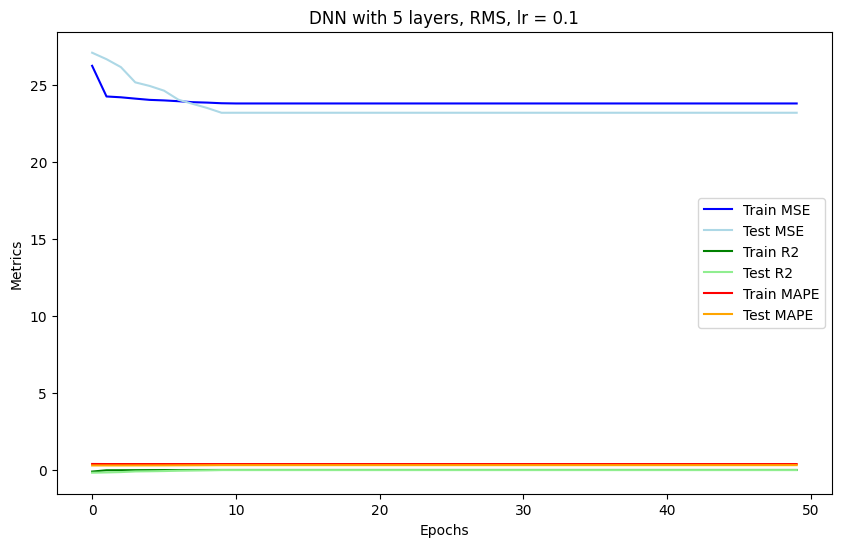

In [77]:
draw("DNN with 5 layers, RMS, lr = 0.1", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [79]:
model = NeuralNetwork(5, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "RMS", 0.01)

Epoch 1/50 - Train MSE: 11.2398, Test MSE: 4.5668
Epoch 2/50 - Train MSE: 7.8511, Test MSE: 4.2120
Epoch 3/50 - Train MSE: 7.1579, Test MSE: 3.3450
Epoch 4/50 - Train MSE: 5.3841, Test MSE: 2.2499
Epoch 5/50 - Train MSE: 4.0212, Test MSE: 1.9706
Epoch 6/50 - Train MSE: 3.4179, Test MSE: 1.3407
Epoch 7/50 - Train MSE: 2.6653, Test MSE: 1.0475
Epoch 8/50 - Train MSE: 2.0295, Test MSE: 1.1312
Epoch 9/50 - Train MSE: 1.7581, Test MSE: 0.8681
Epoch 10/50 - Train MSE: 1.6204, Test MSE: 0.8574
Epoch 11/50 - Train MSE: 1.5061, Test MSE: 0.9494
Epoch 12/50 - Train MSE: 1.4130, Test MSE: 1.0172
Epoch 13/50 - Train MSE: 1.3449, Test MSE: 1.0243
Epoch 14/50 - Train MSE: 1.2780, Test MSE: 1.1060
Epoch 15/50 - Train MSE: 1.2100, Test MSE: 1.1067
Epoch 16/50 - Train MSE: 1.1606, Test MSE: 1.0945
Epoch 17/50 - Train MSE: 1.0893, Test MSE: 0.5769
Epoch 18/50 - Train MSE: 1.0291, Test MSE: 0.8395
Epoch 19/50 - Train MSE: 0.9470, Test MSE: 0.5977
Epoch 20/50 - Train MSE: 0.8923, Test MSE: 0.3591
Epoch 21

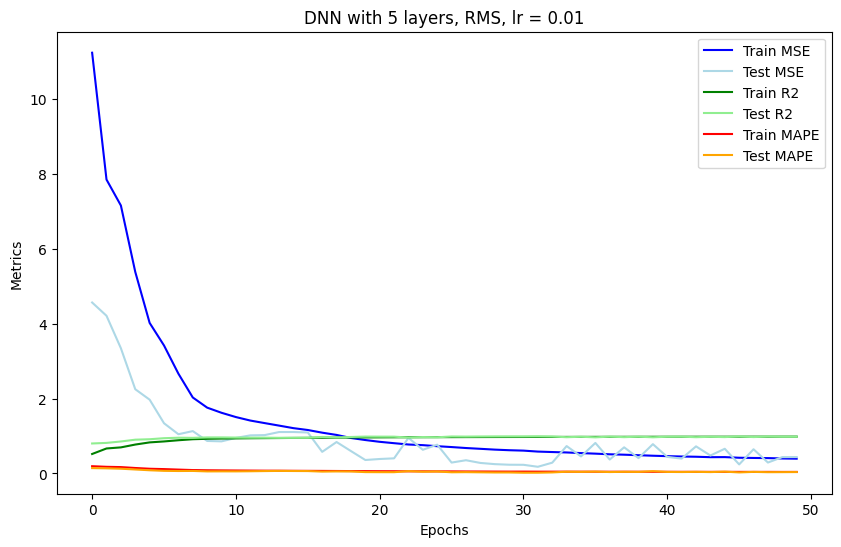

In [80]:
draw("DNN with 5 layers, RMS, lr = 0.01", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [81]:
model = NeuralNetwork(5, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "RMS", 0.001)

Epoch 1/50 - Train MSE: 27.8675, Test MSE: 4.7871
Epoch 2/50 - Train MSE: 5.9482, Test MSE: 4.4573
Epoch 3/50 - Train MSE: 5.8961, Test MSE: 4.3328
Epoch 4/50 - Train MSE: 5.8443, Test MSE: 4.1858
Epoch 5/50 - Train MSE: 5.7465, Test MSE: 4.0124
Epoch 6/50 - Train MSE: 5.5725, Test MSE: 3.8046
Epoch 7/50 - Train MSE: 5.3392, Test MSE: 3.4765
Epoch 8/50 - Train MSE: 5.0386, Test MSE: 3.1310
Epoch 9/50 - Train MSE: 4.7612, Test MSE: 2.8537
Epoch 10/50 - Train MSE: 4.5539, Test MSE: 2.6714
Epoch 11/50 - Train MSE: 4.3975, Test MSE: 2.4733
Epoch 12/50 - Train MSE: 4.2694, Test MSE: 2.3004
Epoch 13/50 - Train MSE: 4.1605, Test MSE: 2.1548
Epoch 14/50 - Train MSE: 4.0563, Test MSE: 1.9948
Epoch 15/50 - Train MSE: 3.9526, Test MSE: 1.8947
Epoch 16/50 - Train MSE: 3.8613, Test MSE: 1.8447
Epoch 17/50 - Train MSE: 3.7904, Test MSE: 1.7655
Epoch 18/50 - Train MSE: 3.7452, Test MSE: 1.7156
Epoch 19/50 - Train MSE: 3.7192, Test MSE: 1.6769
Epoch 20/50 - Train MSE: 3.7041, Test MSE: 1.6553
Epoch 21

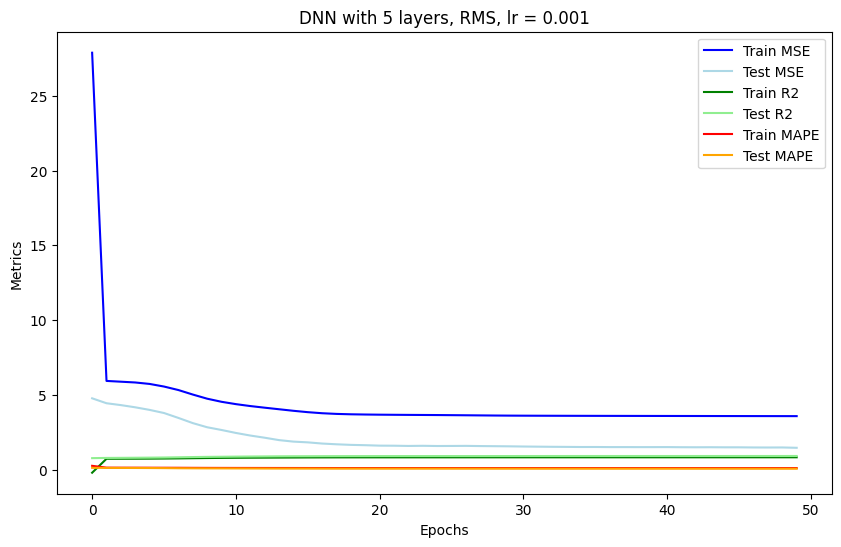

In [82]:
draw("DNN with 5 layers, RMS, lr = 0.001", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [83]:
model = NeuralNetwork(5, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "Adam", 0.1)

Epoch 1/50 - Train MSE: 10.7287, Test MSE: 3.6726
Epoch 2/50 - Train MSE: 3.0036, Test MSE: 1.0622
Epoch 3/50 - Train MSE: 1.9466, Test MSE: 1.6768
Epoch 4/50 - Train MSE: 1.8848, Test MSE: 1.3468
Epoch 5/50 - Train MSE: 1.8659, Test MSE: 1.2361
Epoch 6/50 - Train MSE: 1.8641, Test MSE: 1.4402
Epoch 7/50 - Train MSE: 1.8214, Test MSE: 1.2078
Epoch 8/50 - Train MSE: 1.7677, Test MSE: 1.0559
Epoch 9/50 - Train MSE: 1.7405, Test MSE: 1.0968
Epoch 10/50 - Train MSE: 1.7237, Test MSE: 1.0856
Epoch 11/50 - Train MSE: 1.7135, Test MSE: 1.0667
Epoch 12/50 - Train MSE: 1.7279, Test MSE: 1.1544
Epoch 13/50 - Train MSE: 1.6965, Test MSE: 1.0826
Epoch 14/50 - Train MSE: 1.6921, Test MSE: 1.1987
Epoch 15/50 - Train MSE: 1.6156, Test MSE: 1.2479
Epoch 16/50 - Train MSE: 1.5953, Test MSE: 1.1623
Epoch 17/50 - Train MSE: 1.5779, Test MSE: 1.3062
Epoch 18/50 - Train MSE: 1.5708, Test MSE: 1.2953
Epoch 19/50 - Train MSE: 1.5622, Test MSE: 1.3197
Epoch 20/50 - Train MSE: 1.5625, Test MSE: 1.3205
Epoch 21

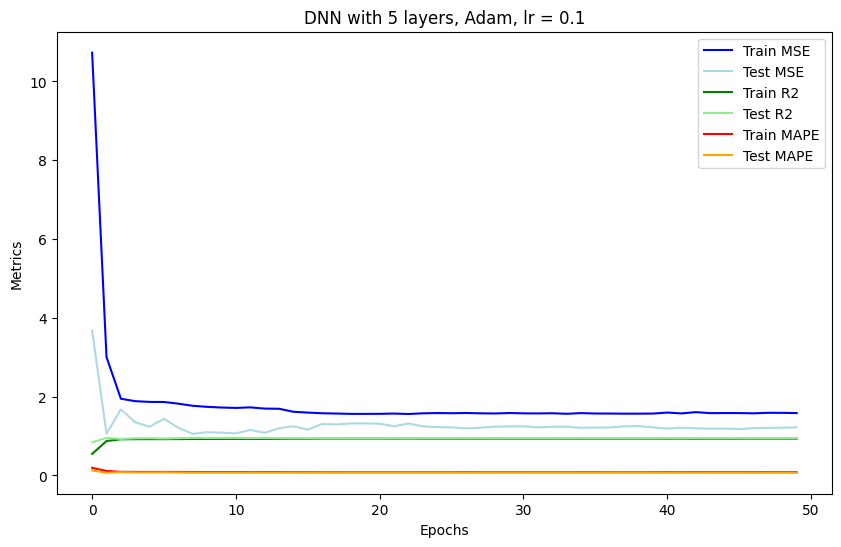

In [84]:
draw("DNN with 5 layers, Adam, lr = 0.1", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [85]:
model = NeuralNetwork(5, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "Adam", 0.01)

Epoch 1/50 - Train MSE: 15.5621, Test MSE: 4.7522
Epoch 2/50 - Train MSE: 6.0264, Test MSE: 5.0205
Epoch 3/50 - Train MSE: 5.7211, Test MSE: 3.5324
Epoch 4/50 - Train MSE: 4.0116, Test MSE: 3.1449
Epoch 5/50 - Train MSE: 3.0678, Test MSE: 0.9843
Epoch 6/50 - Train MSE: 1.4827, Test MSE: 0.9680
Epoch 7/50 - Train MSE: 1.4448, Test MSE: 0.9237
Epoch 8/50 - Train MSE: 1.4311, Test MSE: 0.9064
Epoch 9/50 - Train MSE: 1.4262, Test MSE: 0.9382
Epoch 10/50 - Train MSE: 1.4218, Test MSE: 0.9718
Epoch 11/50 - Train MSE: 1.4196, Test MSE: 0.9666
Epoch 12/50 - Train MSE: 1.4211, Test MSE: 0.9619
Epoch 13/50 - Train MSE: 1.4146, Test MSE: 0.9680
Epoch 14/50 - Train MSE: 1.4138, Test MSE: 0.9604
Epoch 15/50 - Train MSE: 1.4129, Test MSE: 0.9447
Epoch 16/50 - Train MSE: 1.4113, Test MSE: 0.9440
Epoch 17/50 - Train MSE: 1.4100, Test MSE: 0.9420
Epoch 18/50 - Train MSE: 1.4093, Test MSE: 0.9369
Epoch 19/50 - Train MSE: 1.4083, Test MSE: 0.9375
Epoch 20/50 - Train MSE: 1.4077, Test MSE: 0.9361
Epoch 21

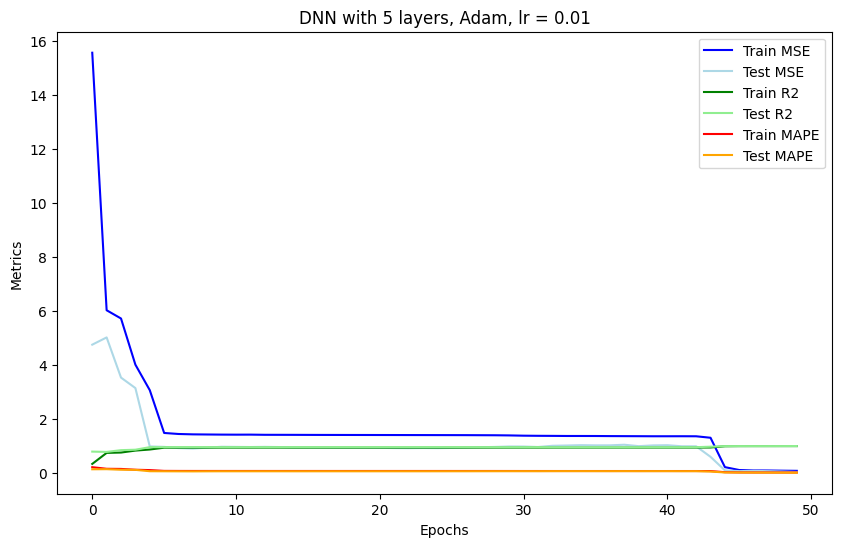

In [86]:
draw("DNN with 5 layers, Adam, lr = 0.01", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [87]:
model = NeuralNetwork(5, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "Adam", 0.001)

Epoch 1/50 - Train MSE: 57.5013, Test MSE: 5.9546
Epoch 2/50 - Train MSE: 6.1808, Test MSE: 4.7958
Epoch 3/50 - Train MSE: 5.9474, Test MSE: 4.7171
Epoch 4/50 - Train MSE: 5.9371, Test MSE: 4.7044
Epoch 5/50 - Train MSE: 5.9399, Test MSE: 4.7118
Epoch 6/50 - Train MSE: 5.9427, Test MSE: 4.7251
Epoch 7/50 - Train MSE: 5.9443, Test MSE: 4.7346
Epoch 8/50 - Train MSE: 5.9450, Test MSE: 4.7397
Epoch 9/50 - Train MSE: 5.9452, Test MSE: 4.7421
Epoch 10/50 - Train MSE: 5.9452, Test MSE: 4.7431
Epoch 11/50 - Train MSE: 5.9451, Test MSE: 4.7432
Epoch 12/50 - Train MSE: 5.9450, Test MSE: 4.7428
Epoch 13/50 - Train MSE: 5.9448, Test MSE: 4.7423
Epoch 14/50 - Train MSE: 5.9446, Test MSE: 4.7417
Epoch 15/50 - Train MSE: 5.9444, Test MSE: 4.7408
Epoch 16/50 - Train MSE: 5.9441, Test MSE: 4.7398
Epoch 17/50 - Train MSE: 5.9438, Test MSE: 4.7385
Epoch 18/50 - Train MSE: 5.9433, Test MSE: 4.7359
Epoch 19/50 - Train MSE: 5.9419, Test MSE: 4.7304
Epoch 20/50 - Train MSE: 5.9383, Test MSE: 4.7131
Epoch 21

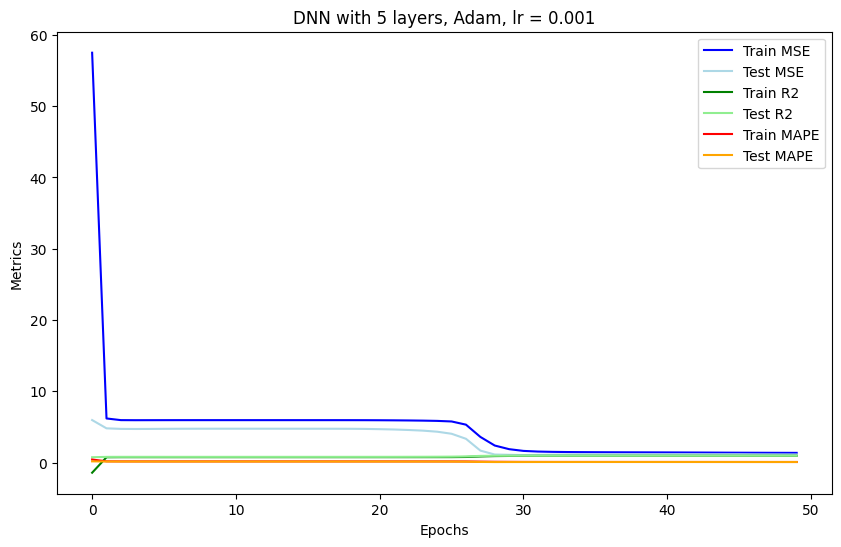

In [88]:
draw("DNN with 5 layers, Adam, lr = 0.001", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [89]:
model = NeuralNetwork(25, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "SGD", 0.1)

Epoch 1/50 - Train MSE: 26.5108, Test MSE: 23.1609
Epoch 2/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 3/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 4/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 5/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 6/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 7/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 8/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 9/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 10/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 11/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 12/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 13/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 14/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 15/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 16/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 17/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 18/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 19/50 - Train MSE: 23.8096, Test MSE: 23.1609
Epoch 20/50 - Train M

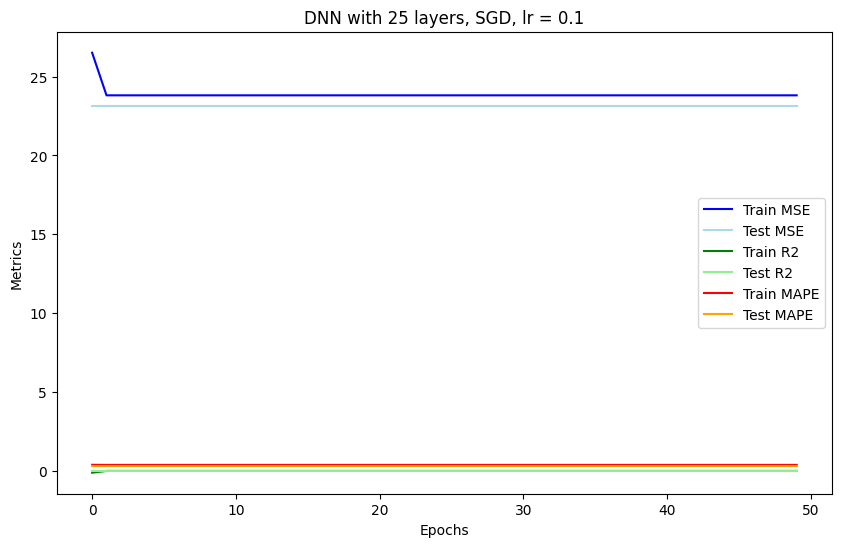

In [90]:
draw("DNN with 25 layers, SGD, lr = 0.1", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [91]:
model = NeuralNetwork(25, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "SGD", 0.01)

Epoch 1/50 - Train MSE: 26.9093, Test MSE: 24.6933
Epoch 2/50 - Train MSE: 23.9426, Test MSE: 24.2386
Epoch 3/50 - Train MSE: 23.9109, Test MSE: 24.0280
Epoch 4/50 - Train MSE: 23.8934, Test MSE: 23.8939
Epoch 5/50 - Train MSE: 23.8814, Test MSE: 23.7910
Epoch 6/50 - Train MSE: 23.8719, Test MSE: 23.7065
Epoch 7/50 - Train MSE: 23.8641, Test MSE: 23.6355
Epoch 8/50 - Train MSE: 23.8574, Test MSE: 23.5758
Epoch 9/50 - Train MSE: 23.8518, Test MSE: 23.5259
Epoch 10/50 - Train MSE: 23.8471, Test MSE: 23.4847
Epoch 11/50 - Train MSE: 23.8432, Test MSE: 23.4512
Epoch 12/50 - Train MSE: 23.8399, Test MSE: 23.4243
Epoch 13/50 - Train MSE: 23.8373, Test MSE: 23.4029
Epoch 14/50 - Train MSE: 23.8352, Test MSE: 23.3862
Epoch 15/50 - Train MSE: 23.8336, Test MSE: 23.3732
Epoch 16/50 - Train MSE: 23.8323, Test MSE: 23.3633
Epoch 17/50 - Train MSE: 23.8313, Test MSE: 23.3557
Epoch 18/50 - Train MSE: 23.8306, Test MSE: 23.3499
Epoch 19/50 - Train MSE: 23.8300, Test MSE: 23.3454
Epoch 20/50 - Train M

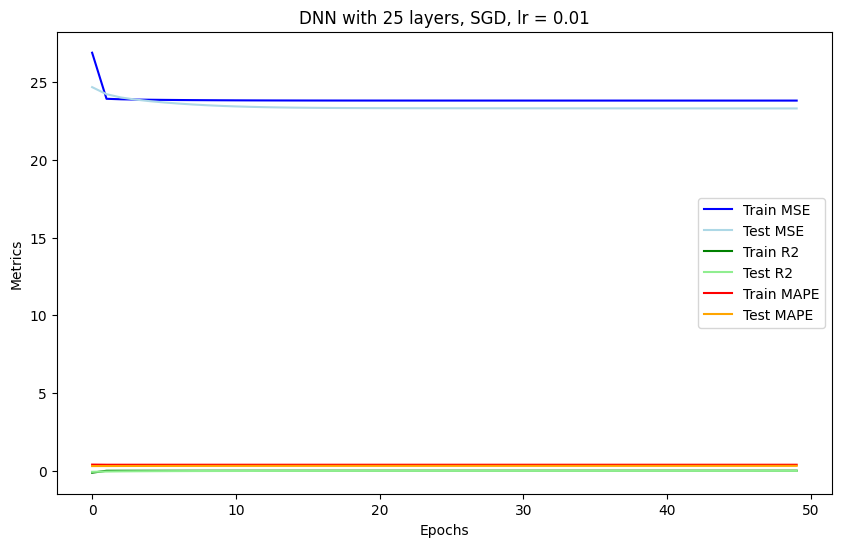

In [92]:
draw("DNN with 25 layers, SGD, lr = 0.01", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [93]:
model = NeuralNetwork(25, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "SGD", 0.001)

Epoch 1/50 - Train MSE: 40.7187, Test MSE: 23.2666
Epoch 2/50 - Train MSE: 23.8205, Test MSE: 23.2652
Epoch 3/50 - Train MSE: 23.8204, Test MSE: 23.2641
Epoch 4/50 - Train MSE: 23.8203, Test MSE: 23.2631
Epoch 5/50 - Train MSE: 23.8201, Test MSE: 23.2620
Epoch 6/50 - Train MSE: 23.8200, Test MSE: 23.2610
Epoch 7/50 - Train MSE: 23.8199, Test MSE: 23.2600
Epoch 8/50 - Train MSE: 23.8198, Test MSE: 23.2590
Epoch 9/50 - Train MSE: 23.8197, Test MSE: 23.2580
Epoch 10/50 - Train MSE: 23.8196, Test MSE: 23.2570
Epoch 11/50 - Train MSE: 23.8194, Test MSE: 23.2560
Epoch 12/50 - Train MSE: 23.8193, Test MSE: 23.2551
Epoch 13/50 - Train MSE: 23.8192, Test MSE: 23.2541
Epoch 14/50 - Train MSE: 23.8191, Test MSE: 23.2532
Epoch 15/50 - Train MSE: 23.8190, Test MSE: 23.2523
Epoch 16/50 - Train MSE: 23.8189, Test MSE: 23.2513
Epoch 17/50 - Train MSE: 23.8188, Test MSE: 23.2504
Epoch 18/50 - Train MSE: 23.8187, Test MSE: 23.2496
Epoch 19/50 - Train MSE: 23.8186, Test MSE: 23.2487
Epoch 20/50 - Train M

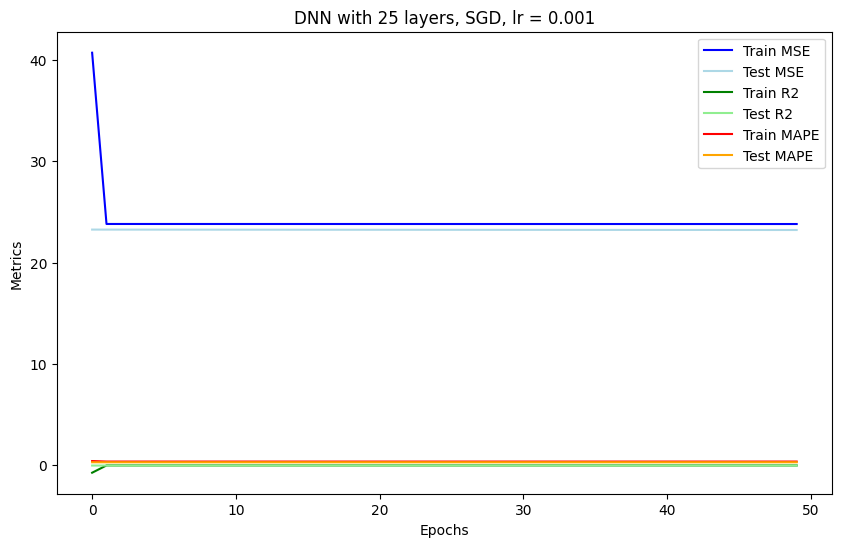

In [94]:
draw("DNN with 25 layers, SGD, lr = 0.001", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [98]:
model = NeuralNetwork(25, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "RMS", 0.1)

Epoch 1/50 - Train MSE: 240626719035440.6562, Test MSE: 29.9081
Epoch 2/50 - Train MSE: 24.7297, Test MSE: 29.9883
Epoch 3/50 - Train MSE: 24.4868, Test MSE: 25.9986
Epoch 4/50 - Train MSE: 24.3101, Test MSE: 27.1271
Epoch 5/50 - Train MSE: 24.2403, Test MSE: 25.3315
Epoch 6/50 - Train MSE: 25.2197, Test MSE: 28.4271
Epoch 7/50 - Train MSE: 24.8783, Test MSE: 25.1410
Epoch 8/50 - Train MSE: 24.1879, Test MSE: 23.4772
Epoch 9/50 - Train MSE: 23.8559, Test MSE: 23.4987
Epoch 10/50 - Train MSE: 23.8944, Test MSE: 24.9289
Epoch 11/50 - Train MSE: 24.1127, Test MSE: 24.7543
Epoch 12/50 - Train MSE: 23.9056, Test MSE: 23.5027
Epoch 13/50 - Train MSE: 23.8214, Test MSE: 23.2117
Epoch 14/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 15/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 16/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 17/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 18/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 19/50 - Train MSE: 23.8159, Test MSE: 23.2119
Epoch 20

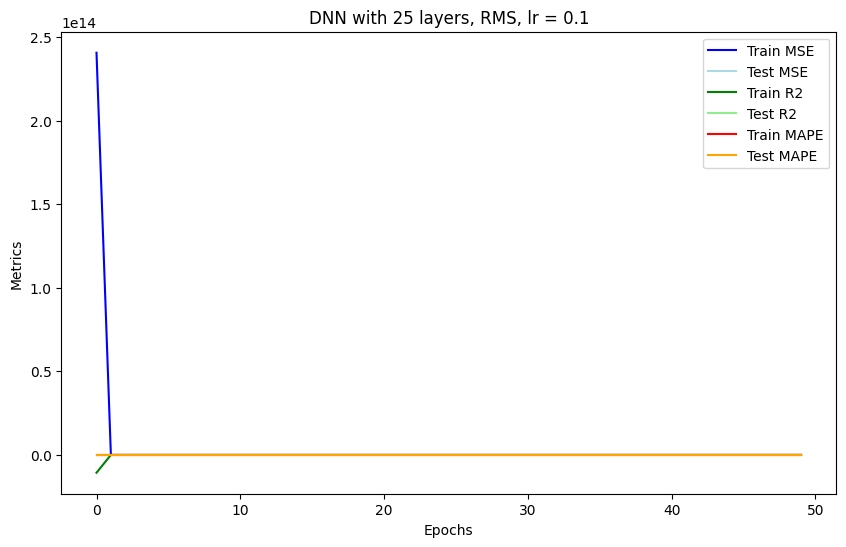

In [99]:
draw("DNN with 25 layers, RMS, lr = 0.1", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [100]:
model = NeuralNetwork(25, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "RMS", 0.01)

Epoch 1/50 - Train MSE: 21.3954, Test MSE: 11.0839
Epoch 2/50 - Train MSE: 8.8539, Test MSE: 4.9414
Epoch 3/50 - Train MSE: 7.8740, Test MSE: 2.3716
Epoch 4/50 - Train MSE: 4.4546, Test MSE: 2.7341
Epoch 5/50 - Train MSE: 3.7409, Test MSE: 1.9000
Epoch 6/50 - Train MSE: 2.9362, Test MSE: 2.5162
Epoch 7/50 - Train MSE: 2.6283, Test MSE: 8.2823
Epoch 8/50 - Train MSE: 2.5094, Test MSE: 0.9790
Epoch 9/50 - Train MSE: 2.1799, Test MSE: 1.5169
Epoch 10/50 - Train MSE: 2.0298, Test MSE: 0.9304
Epoch 11/50 - Train MSE: 1.9725, Test MSE: 0.9632
Epoch 12/50 - Train MSE: 1.7689, Test MSE: 1.7965
Epoch 13/50 - Train MSE: 1.6735, Test MSE: 0.8000
Epoch 14/50 - Train MSE: 1.6100, Test MSE: 0.4630
Epoch 15/50 - Train MSE: 1.5042, Test MSE: 0.4691
Epoch 16/50 - Train MSE: 1.5260, Test MSE: 11.5295
Epoch 17/50 - Train MSE: 2.0763, Test MSE: 0.3347
Epoch 18/50 - Train MSE: 2.0474, Test MSE: 0.2993
Epoch 19/50 - Train MSE: 1.5433, Test MSE: 1.7216
Epoch 20/50 - Train MSE: 1.4780, Test MSE: 0.3332
Epoch 

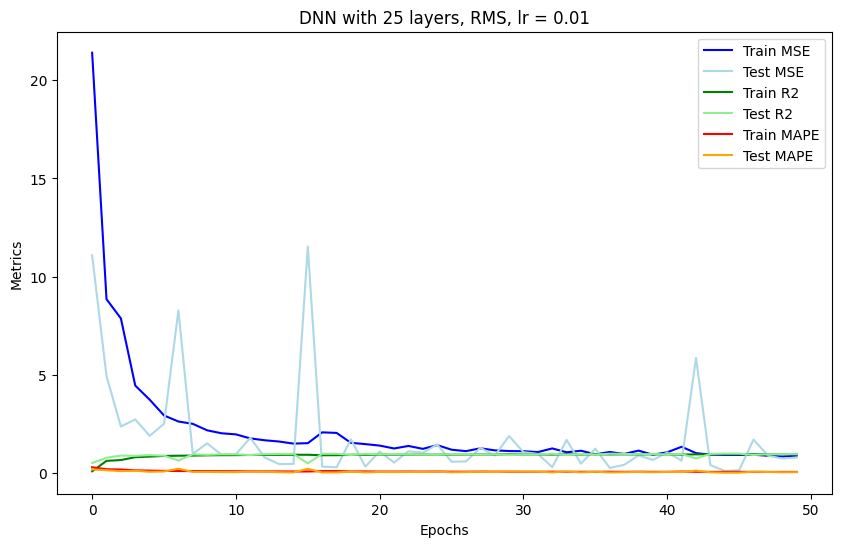

In [101]:
draw("DNN with 25 layers, RMS, lr = 0.01", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [102]:
model = NeuralNetwork(25, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "RMS", 0.001)

Epoch 1/50 - Train MSE: 20.0064, Test MSE: 4.9849
Epoch 2/50 - Train MSE: 6.3920, Test MSE: 4.1396
Epoch 3/50 - Train MSE: 6.0581, Test MSE: 3.8427
Epoch 4/50 - Train MSE: 5.8445, Test MSE: 3.5883
Epoch 5/50 - Train MSE: 5.6211, Test MSE: 3.2384
Epoch 6/50 - Train MSE: 5.3291, Test MSE: 2.7756
Epoch 7/50 - Train MSE: 4.9665, Test MSE: 2.2363
Epoch 8/50 - Train MSE: 4.5192, Test MSE: 1.8325
Epoch 9/50 - Train MSE: 4.0496, Test MSE: 1.5797
Epoch 10/50 - Train MSE: 3.7474, Test MSE: 1.1098
Epoch 11/50 - Train MSE: 3.5489, Test MSE: 1.2946
Epoch 12/50 - Train MSE: 3.4125, Test MSE: 1.5512
Epoch 13/50 - Train MSE: 3.3322, Test MSE: 1.6113
Epoch 14/50 - Train MSE: 3.2660, Test MSE: 1.5695
Epoch 15/50 - Train MSE: 3.2155, Test MSE: 1.5112
Epoch 16/50 - Train MSE: 3.1815, Test MSE: 1.5352
Epoch 17/50 - Train MSE: 3.1422, Test MSE: 1.4841
Epoch 18/50 - Train MSE: 3.0992, Test MSE: 1.4243
Epoch 19/50 - Train MSE: 3.0506, Test MSE: 1.4268
Epoch 20/50 - Train MSE: 3.0044, Test MSE: 1.4910
Epoch 21

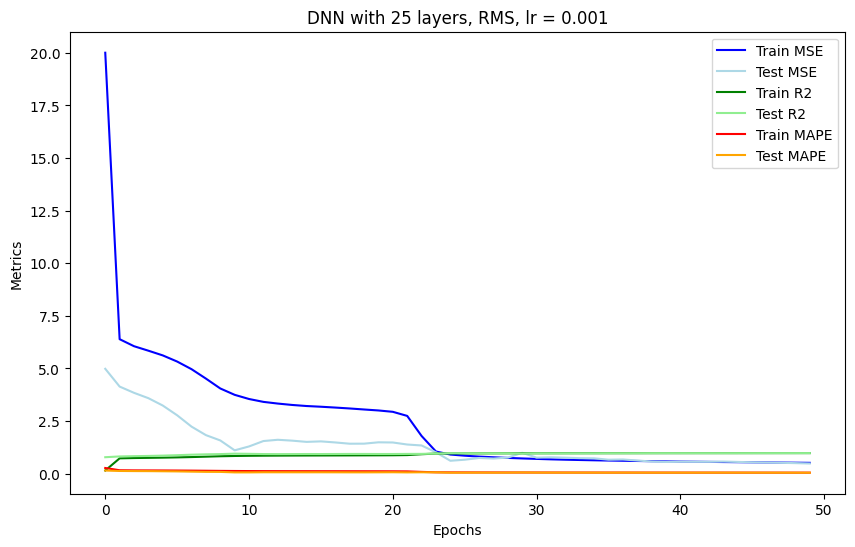

In [103]:
draw("DNN with 25 layers, RMS, lr = 0.001", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [104]:
model = NeuralNetwork(25, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "Adam", 0.1)

Epoch 1/50 - Train MSE: 160.0380, Test MSE: 23.0595
Epoch 2/50 - Train MSE: 23.8004, Test MSE: 23.0163
Epoch 3/50 - Train MSE: 23.8013, Test MSE: 23.0099
Epoch 4/50 - Train MSE: 23.8019, Test MSE: 23.0129
Epoch 5/50 - Train MSE: 23.8026, Test MSE: 23.0257
Epoch 6/50 - Train MSE: 23.8035, Test MSE: 23.0434
Epoch 7/50 - Train MSE: 23.8049, Test MSE: 23.0567
Epoch 8/50 - Train MSE: 23.8067, Test MSE: 23.0612
Epoch 9/50 - Train MSE: 23.8091, Test MSE: 23.0597
Epoch 10/50 - Train MSE: 23.8121, Test MSE: 23.0513
Epoch 11/50 - Train MSE: 23.8150, Test MSE: 23.0451
Epoch 12/50 - Train MSE: 23.8179, Test MSE: 23.0543
Epoch 13/50 - Train MSE: 23.8207, Test MSE: 23.0778
Epoch 14/50 - Train MSE: 23.8229, Test MSE: 23.1044
Epoch 15/50 - Train MSE: 23.8242, Test MSE: 23.1206
Epoch 16/50 - Train MSE: 23.8243, Test MSE: 23.1153
Epoch 17/50 - Train MSE: 23.8229, Test MSE: 23.0877
Epoch 18/50 - Train MSE: 23.8202, Test MSE: 23.0555
Epoch 19/50 - Train MSE: 23.8170, Test MSE: 23.0440
Epoch 20/50 - Train 

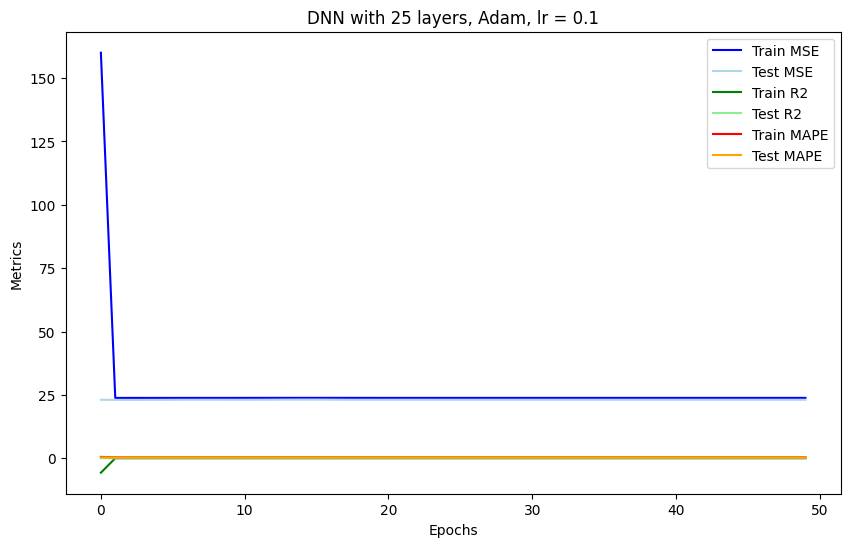

In [105]:
draw("DNN with 25 layers, Adam, lr = 0.1", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [106]:
model = NeuralNetwork(25, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "Adam", 0.01)

Epoch 1/50 - Train MSE: 29.7329, Test MSE: 23.4172
Epoch 2/50 - Train MSE: 23.9253, Test MSE: 23.5066
Epoch 3/50 - Train MSE: 23.9254, Test MSE: 23.4132
Epoch 4/50 - Train MSE: 23.9209, Test MSE: 23.2131
Epoch 5/50 - Train MSE: 23.9168, Test MSE: 23.0929
Epoch 6/50 - Train MSE: 23.9145, Test MSE: 23.1552
Epoch 7/50 - Train MSE: 23.9088, Test MSE: 23.1443
Epoch 8/50 - Train MSE: 23.9003, Test MSE: 23.1085
Epoch 9/50 - Train MSE: 23.8937, Test MSE: 23.1077
Epoch 10/50 - Train MSE: 23.8880, Test MSE: 23.1240
Epoch 11/50 - Train MSE: 23.8830, Test MSE: 23.1368
Epoch 12/50 - Train MSE: 23.8782, Test MSE: 23.1468
Epoch 13/50 - Train MSE: 23.8738, Test MSE: 23.1578
Epoch 14/50 - Train MSE: 23.8699, Test MSE: 23.1708
Epoch 15/50 - Train MSE: 23.8666, Test MSE: 23.1869
Epoch 16/50 - Train MSE: 23.8633, Test MSE: 23.2072
Epoch 17/50 - Train MSE: 23.8603, Test MSE: 23.2316
Epoch 18/50 - Train MSE: 23.8590, Test MSE: 23.2531
Epoch 19/50 - Train MSE: 23.8545, Test MSE: 23.2861
Epoch 20/50 - Train M

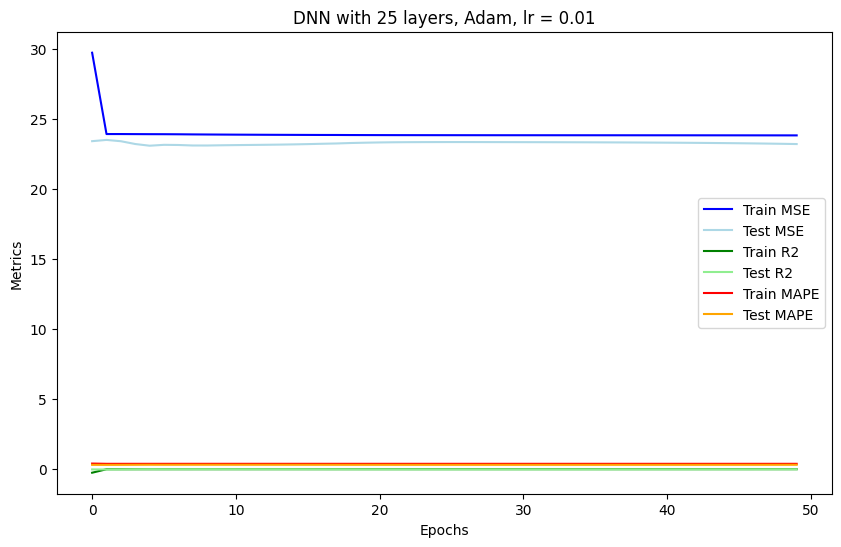

In [107]:
draw("DNN with 25 layers, Adam, lr = 0.01", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

In [108]:
model = NeuralNetwork(25, 10, 1)
train_r2, test_r2, train_mape, test_mape, train_mse, test_mse = train(model, "Adam", 0.001)

Epoch 1/50 - Train MSE: 95.0860, Test MSE: 4.0021
Epoch 2/50 - Train MSE: 4.6789, Test MSE: 2.9060
Epoch 3/50 - Train MSE: 3.5369, Test MSE: 2.1883
Epoch 4/50 - Train MSE: 3.1611, Test MSE: 1.9553
Epoch 5/50 - Train MSE: 2.9648, Test MSE: 1.6804
Epoch 6/50 - Train MSE: 2.7838, Test MSE: 1.4095
Epoch 7/50 - Train MSE: 1.5607, Test MSE: 0.3621
Epoch 8/50 - Train MSE: 0.4814, Test MSE: 0.1481
Epoch 9/50 - Train MSE: 0.3541, Test MSE: 0.1070
Epoch 10/50 - Train MSE: 0.2813, Test MSE: 0.1072
Epoch 11/50 - Train MSE: 0.2349, Test MSE: 0.1354
Epoch 12/50 - Train MSE: 0.2017, Test MSE: 0.1326
Epoch 13/50 - Train MSE: 0.1772, Test MSE: 0.1131
Epoch 14/50 - Train MSE: 0.1580, Test MSE: 0.0971
Epoch 15/50 - Train MSE: 0.1389, Test MSE: 0.0832
Epoch 16/50 - Train MSE: 0.1248, Test MSE: 0.0787
Epoch 17/50 - Train MSE: 0.1141, Test MSE: 0.0850
Epoch 18/50 - Train MSE: 0.1059, Test MSE: 0.0877
Epoch 19/50 - Train MSE: 0.0990, Test MSE: 0.0883
Epoch 20/50 - Train MSE: 0.0938, Test MSE: 0.0843
Epoch 21

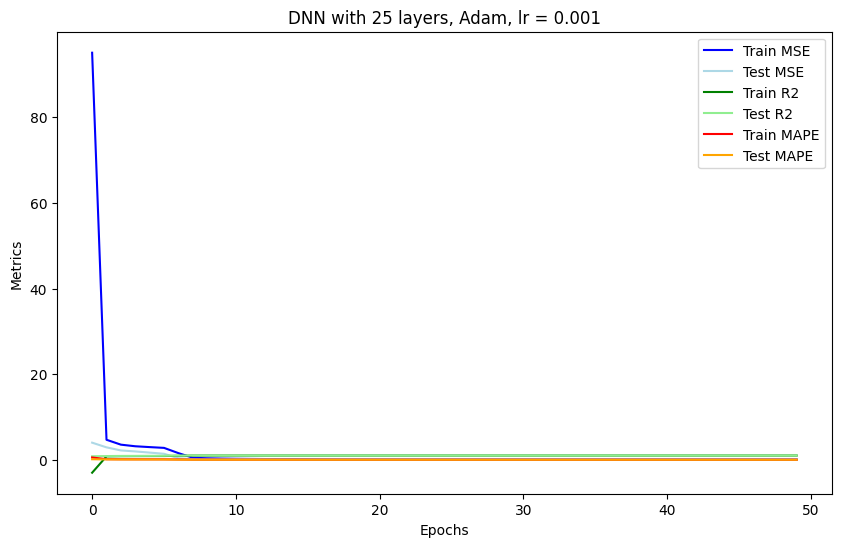

In [109]:
draw("DNN with 25 layers, Adam, lr = 0.001", train_r2, test_r2, train_mape, test_mape, train_mse, test_mse)

# Results

Найкращі результати:
*   модель з 5 шарами, оптимізатор "SGD", крок навчання 0.01
*   модель з 5 шарами, оптимізатор "RMS", крок навчання 0.01
*   модель з 5 шарами, оптимізатор "Adam", крок навчання 0.01
*   модель з 25 шарами, оптимізатор "RMS", крок навчання 0.01
*   модель з 25 шарами, оптимізатор "Adam", крок навчання 0.001











